## **README** <br/>

**Project Name:** Machine Translation <br/>
**Date:** 30.06.2021 <br/>
**Task:** This project aims to build an architecture capable of translating german to english natural language. We are implementing the concepts of Bahdanau et al., (2015) (https://arxiv.org/pdf/1409.0473.pdf).

This tutorial was used as a basic guideline: https://towardsdatascience.com/neural-machine-translation-nmt-with-attention-mechanism-5e59b57bd2ac?gi=10b3656615f0 <br/>
We have extended this by adding the following points: <br/>
1. Custom preprocessing
2. Adding bidirectional (instead of unidirectional) LSTM

# Datasets #
This notebook can work with different datasets. It expects it to be in the same folder as this notebook. The dataset should include the source language and target language, so there are two files each in total. The naming should be as follows:

*   For the EUROPARL dataset (https://www.statmt.org/europarl/):
  1.   German: `europarl-v7.de-en.de`
  2.   English: `europarl-v7.en-de.de`
*   For the ELRC dataset (provided in the LEA folder, as we preprocessed it manually):
  1.   German: `de_tmx.txt`
  2.   English: `en_tmx.txt`
*   For the RAPID dataset (http://www.statmt.org/wmt19/translation-task.html):
  1.   German: `rapid2019.de-en.de`
  2.   English: `rapid2019.de-en.en`

# Execution #
Every cell, which needs to be executed in order to reproduce the model, is labelled with: <br/>
**-- Run this cell --**

## **Imports** <br/>
**-- Run this cell --** <br/>
Imports the necessary libraries

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

import re

import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from datetime import datetime

from unicodedata import normalize

import time
import datetime

import random

import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dominik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **General** <br/>
**-- Run this cell --** <br/>
A custom log function to print log messages

In [ ]:
# Log a message
def log(msg, msg_type="info", overwrite_last=False):
    timestamp = datetime.datetime.today().strftime('%Y-%m-%d %H:%M:%S')
    
    if msg_type is "warning":
        tpe = "WARN"
    elif msg_type is "error":
        tpe = "ERROR"
    else:
        tpe = "INFO"

    print("[" + timestamp + "] --- [" + tpe + "]: " + msg, end = '\n' if not overwrite_last else '\r')

## **Datasets** <br/>
**-- Run this cell --** <br/>
Change the variable `dataset` to:

*   0: for EUROPARL dataset
*   1: for ELRC dataset
*   2: for RAPID dataset





In [ ]:
dataset = 0 # Change this value
FILE_DE = None
FILE_EN = None
if dataset == 0:
    """
        EUROPARL Dataset
        Samples: 1.9M
        Source: https://www.statmt.org/europarl/
        Description: Political speeches
    """
    EUROPARL = ('./europarl-v7.de-en.de', './europarl-v7.de-en.en')
    FILE_DE = EUROPARL[0]
    FILE_EN = EUROPARL[1]
    log("Using EUROPARL dataset")
elif dataset == 1:
    """
        ELRC Dataset
        Samples: ~53K
        Source: https://data.europa.eu/data/datasets/elrc_41?locale=en
        Description: German-English texts extracted from the website of the Federal Foreign Office Berlin. 
    """
    TMX = ('./de_tmx.txt', './en_tmx.txt')
    FILE_DE = TMX[0]
    FILE_EN = TMX[1]
    log("Using ELRC dataset")
elif dataset == 2:
    """
        RAPID Dataset
        Samples: ~1.5M
        Source: http://www.statmt.org/wmt19/translation-task.html
        Description: Sentences in the style of news reports
    """
    RAPID = ('./rapid2019.de-en.de', './rapid2019.de-en.en')
    FILE_DE = RAPID[0]
    FILE_EN = RAPID[1]
    log("Using RAPID dataset")
else:
    FILE_DE = None
    FILE_EN = None
    log("Please select a valid dataset", msg_type="error")

[2021-06-30 00:41:00] --- [INFO]: Using EUROPARL dataset


**-- Do *NOT* run this cell --**<br/>
This cell is just for reference purposes. It was used for creating a custom dataset by combining samples from all other datasets. If executed, it will create two dataset files, one for each language. <br/>
If that dataset should be used, it has to be specified in `FILE_DE` and `FILE_EN` above. This will overwrite the previous setting above.

In [ ]:
"""
  Class for merging several datasets into a single one.
  This creates two files containing source and target language sentences
"""
class DatasetCreator:
    def __init__(self, datasets, total_size, min_sent_len=1, max_sent_len=32, file_output_name=None):
        """
          Arguments:
            datasets: Tuple(string, string)
              Filenames of the datasets to use. Each Tuple represents the source and target dataset name.(!) Datasets are expected to be parallel, line by line translations (!)
            total_size: Number
              Total amount of samples after merging the datasets together
            min_sent_len: Number
              Use only sentences which have this specified length
            max_sent_len: Number
              Use only sentences which are shorter or equal to this length
        """
        
        # self.datasets will contain a list of lists, each representing a single dataset
        self.datasets = []
        log("Loading datasets ...")
        count = 0
        for dataset in datasets:
            log(" > " + str(count) + "/" + str(len(datasets)))
            source = dataset[0]
            target = dataset[1]
            with open(source, mode='rt', encoding='utf-8') as f:
                src_dt = f.read().strip().split('\n')
            with open(target, mode='rt', encoding='utf-8') as f:
                tgt_dt = f.read().strip().split('\n')
          
            # Append a Tuple of (src_dataset, tgt_dataset) to self.datasets
            self.datasets.append((src_dt, tgt_dt))

        count += 1
        log("All datasets loaded")

        self.total_size = total_size
        self.min_sent_len = min_sent_len
        self.max_sent_len = max_sent_len
        self.file_output_name = file_output_name if file_output_name else str(time.time()) + '_mixed_dataset.txt'
    

    def __get_sample_size(self):
        return int(round(self.total_size / len(self.datasets)))


    def __dump_to_file(self, merged_dataset):
        log("Writing new dataset to file")
        source_filename = 'source_' + self.file_output_name
        target_filename = 'target_' + self.file_output_name
        source_output = open(source_filename, 'w')
        target_output = open(target_filename, 'w')
        
        count = 0
        total = len(merged_dataset)
        for sample_pair in merged_dataset:
            if count % 50000 == 0:
                log(" > " + str(count) + "/" + str(total))
            source = sample_pair[0]
            target = sample_pair[1]
            source_output.write(source)
            source_output.write('\n')
            target_output.write(target)
            target_output.write('\n')
            count += 1
        log(" > " + str(count) + "/" + str(total))

        source_output.close()
        target_output.close()

        log("Done. Files saved to " + source_filename + " and " + target_filename)

    def get_file_names(self):
        return 'source_' + self.file_output_name, 'target_' + self.file_output_name

    def build_dataset(self):
        log("Building new dataset ...")
        sample_size = self.__get_sample_size()#
        merged_dataset = [] # Contains Tuples for the final dataset

        # For each dataset to be merged
        count = 0
        sent_count = len(self.datasets)
        for dataset in self.datasets:
            log(" > " + str(count) + "/" + str(sent_count))
            source_dataset = dataset[0]
            target_dataset = dataset[1]
            
            # Retrieve `sample_size` random samples from current dataset
            for i in range(sample_size):

                # Get random index
                minimum = 0
                maximum = min(len(source_dataset), sample_size+1)
                index = random.randint(minimum, maximum-1)

                # Get source and target sentence at that index (Important: Get the same index to ensure consistency)
                source_sentence, target_sentence = source_dataset[index], target_dataset[index]

                # Save Tuple
                merged_dataset.append((source_sentence, target_sentence))

            count += 1
        log(" > " + str(count) + "/" + str(sent_count))  

        # Shuffle dataset
        random.shuffle(merged_dataset)

        # Write merged dataset to file
        self.__dump_to_file(merged_dataset)

        # Release some memory
        del merged_dataset

        log("Done building datasets.")

create = False
if create:
    dataset_creator = DatasetCreator(datasets=[EUROPARL, TMX, RAPID], total_size=1000000)
    dataset_creator.build_dataset()


    """
    # Testing the new file with a few samples
    s = open(src_name, 'r')
    s_data = s.read().strip().split('\n')
    t = open(tgt_name, 'r')
    t_data = t.read().strip().split('\n')
    print("Source Size: ", len(s_data))
    print("Target Size: ", len(t_data))
    for i in range(2):
      index = random.randint(0, 1000000)
      print("Index: ", index)
      print(" > Source: ", s_data[index])
      print(" > Target: ", t_data[index])
      print("\n")

    s.close()
    t.close()
    """

    """
      Merged dataset from EUROPARL, TMX and RAPID
      Samples: 1M
    """
    src_name, tgt_name = dataset_creator.get_file_names()
    CUSTOM = (src_name, tgt_name)
    FILE_DE = CUSTOM[0]
    FILE_EN = CUSTOM[1]
    # Releasing Memory from the instance
    del dataset_creator

## **Global Variables** <br/>
**-- Run this cell --** <br/>
Loading variables used for data preprocessing and training

In [ ]:
# At how many steps a log message should be printed in the DataLoader
PRINT_STEPS = 30000

### Model Variables
VOCAB_SIZE = 5000
NUM_SAMPLES = 10000 # how many samples to use for training
SEQUENCE_LENGTH = 24 # the length to which sentences are trimmed and padded
EMBEDDING_SIZE = 256 # word embedding size

#Tokens
SOS = '<sos>'
EOS = '<eos>'
UNK = '<unk>'

## **Data Loader** <br/>
**-- Run this cell --** <br/>
Class for loading and preprocessing the specified dataset.

In [ ]:
class DataLoader:
    
    def __init__(self, filename, max_vocab=VOCAB_SIZE):
        """
        Initialize the Data Loader
        
        Arguments:
            filename: String
                Takes the filepath+filename to the dataset
            sos: String
                Sequence marking the beginning of a sentence
            eos: String
                Sequence marking the end of a sentence
        """
        
        # Dataset Source
        self.FILE = filename          # Filename
        self.DATA = None              # Original sentences
        self.DATA_PROCESSED = list()  # Tokenized sentences
        self.PADDED_SEQUENCES = list()       # List of padded integer encoded sentences. Length: max_sentence_length
        self.max_vocab = max_vocab
        
        
        # Sentence Sequences
        self.SOS = SOS  # Start sequence
        self.EOS = EOS  # End sequence
        self.UNK = UNK
        
        # Dictionaries
        self.ID_WORD = dict({1:self.UNK}) # Dictionary id:word
        self.WORD_ID = dict({self.UNK:1}) # Dictionary word:id
        
        log("DataLoader Initialized")


    def get_dicts(self):
        """
          Returns the dictionaries id->word and word->id

          Returns
            ID_WORD: dict()
              The dictionary containing the unique id as index and corresponding word as the value
            WORD_ID: dict()
              The dictionary containing the uniwue words as index and corresponding id as the value
        """

        return self.ID_WORD, self.WORD_ID


    def get_sequences(self):
        """
          Returns the padded sequences. These are the integer vectors of every sentence.
          Sentences shorter than `get_sequence_size()` are padded with zeros.

          Returns
            PADDED_SEQUENCES: List[List[int]]
              The padded sequences of the sentences
        """

        return self.PADDED_SEQUENCES


    def get_vocab_size(self):
        """
          Returns the size of the dictionary id->word,
          which is the total amount of unique words in a language
        """

        return len(self.ID_WORD)


    def get_sequence_size(self):
        """
          Return the length of the padded sequences. Currently this is the length of the longest sentence in the dataset.
        """

        return len(self.PADDED_SEQUENCES[0])
        
        
    def read_data(self, delimiter='\n'):    
        """
        Reads the datasets and loads them to a list
        
        Arguments:
            delimiter: String
                The delimiter used to split the dataset. Defaults to '\n'
        """
        log("Reading datasets ...")
        
        # Read source dataset
        with open(self.FILE,mode='rt', encoding='utf-8') as f:
            self.DATA = f.read().strip().split('\n')[:NUM_SAMPLES]
        
        log(" > Done")
        
    
    def print_sample(self, data=True):
        """
        Prints a sample of the dataset for quality check
        
        Arguments:
            data: Boolean
                Whether to print samples from the dataset
        """
        
        if data:
            log("Data:")
            print(self.PADDED_SEQUENCES[0:4])
            
            
    def __process(self, sent):
        """
        Helper method for preprocess()
        """
        
        # Lowercase
        sent = sent.lower()
        
        # Normalize
        sent = self.__normalize_unicode(sent)
        
        # Tokenize
        sent = self.__tokenize(sent)
        
        # Add start and stop sequence
        sent.insert(0, self.SOS)
        sent.append(self.EOS)
        
        return sent

    def get_processed_data(self):
        return self.DATA_PROCESSED
    
    def preprocess(self):
        """
        1. Start and stop markers
        2. ASCII encoding for special characters
        3. Lower Case conversion
        """
        
        log("Preprocessing ...")
        
        log(" > Data ...")
        data_count = len(self.DATA)
        data_i = 0
        for sent in self.DATA:
            if data_i % PRINT_STEPS == 0:
                log(" > " + str(data_i) + '/' + str(data_count))
            data_i += 1
            sent = self.__process(sent)
            
            # Apply changes
            self.DATA_PROCESSED.append(sent)
           
        log(" > " + str(data_i) + '/' + str(data_count))
        log(" > Done")
        
        
    def __normalize_unicode(self, sent):
        """
        Converts sentence to ascii
        """
        # normalize unicode characters
        sent = normalize('NFKD', sent).encode('ascii', 'ignore')
        sent = sent.decode('UTF-8')
        return sent
    
    
    def __tokenize(self, sent):
        """
        Tokenizes the sentence using nltk
        """
        
        sent = word_tokenize(sent)
        return sent
    
    def create_dicts(self):
        """
        Create two dictionaries conatining the id:word and word:id of all datasets combined
        """
        log("Creating dictionary ...")
        
        # Flatten sentences
        #src_flattened = [token for sent in self.DATA_SRC_PROCESSED for token in sent]
        #tgt_flattened = [token for sent in self.DATA_TGT_PROCESSED for token in sent]
        #flattened = src_flattened + tgt_flattened
        
        # Get unique words
        #unique = np.unique(flattened)
        
        # Fill dictionaries
        index = 2 # Start by one because we pad sequences with zeros
        sent_count = 0
        log(" > Tokens ... ")
        size = len(self.DATA_PROCESSED)
        for sent in self.DATA_PROCESSED:
            if sent_count % PRINT_STEPS == 0:
                log(" > " + str(sent_count) + "/" + str(size) + "  sentences processed", overwrite_last=False)
            for token in sent:
                if token not in self.WORD_ID and len(self.WORD_ID) < self.max_vocab:
                    self.ID_WORD[index] = token
                    self.WORD_ID[token] = index
                    index += 1
            sent_count += 1
        log(" > Done ")
        
        log(" > Done (" + str(len(self.ID_WORD)) + ") unique entries added to dictionary")
        
        
    def get_max_length(self):
        return max(map(len, self.DATA_PROCESSED))
    
    def decode_sequence(self, sequence):
        """
          Creates the nlp sentence for a given padded sequence.
        """

        nlp = ''
        for word_id in sequence:
            word = '' if word_id == 0 else self.ID_WORD[word_id]
            nlp += word + ' '
        return nlp.strip()
        
    def pad_sequences(self):
        """
        Pads sequences with the maximum sentence length
        """
        log("Padding sequences ...")
        
        
        max_length = self.get_pad_length()
        
        """
        1. For each sentences in PROCESSED, check length
        2. If length is >= max_length:
          2.1 convert tokens to token_ids
          2.2 replace the last element in the padded sequence with the stop seq
        3. If length is < max_length:
          3.1 convert tokens to token_ids
        """
        for sent in self.DATA_PROCESSED:
            sent_length = len(sent)

            seq = np.zeros(max_length, dtype="uint64")
            if sent_length >= max_length:
                for i in range(0, max_length):
                    # Step 2.1
                    if sent[i] in self.WORD_ID:
                        token_id = self.WORD_ID[sent[i]]
                        seq[i] = token_id
                    else:
                        seq[i] = self.WORD_ID[self.UNK]
                    # Step 2.2
                    seq[max_length-1] = self.WORD_ID[self.EOS]
            else:
                for i in range(0, sent_length):
                    if sent[i] in self.WORD_ID:
                        token_id = self.WORD_ID[sent[i]]
                        seq[i] = token_id
                    else:
                        seq[i] = self.WORD_ID[self.UNK]
            self.PADDED_SEQUENCES.append(seq)

            
        log(" > Done")

    def plot_length(self):
        x = list()
        for each_sent in self.DATA_PROCESSED:
            x.append(len(each_sent))

        y = np.arange(0,len(x),1)

        plt.plot(x,y)

    def get_pad_length(self, quantile=90):
        #lengths = np.array([len(sequence) for sequence in self.DATA_PROCESSED])

        #return int(np.percentile(lengths, quantile))
        return SEQUENCE_LENGTH


    def trim_padding(self, max_length):
        for index,padded_sent in enumerate(self.PADDED_SEQUENCES):
            if np.argmax(np.where(padded_sent!=0))> max_length:
                padded_sent[max_length-1] = self.WORD_ID[self.EOS]
                self.PADDED_SEQUENCES[index] = padded_sent
            else:
                self.PADDED_SEQUENCES[index] = padded_sent[:max_length]

        return self.PADDED_SEQUENCES

    def plot_padded_lengths(self):
        x = list()
        for each_sent in self.PADDED_SEQUENCES:
            x.append(len(each_sent))

        y = np.arange(0,len(x),1)

        plt.plot(x,y)
                 
            


### END OF DATALOADER ###

"""
  Function to return a train, validation, test split on given data
"""
def get_train_val_test_split(src, tgt, max_samples=NUM_SAMPLES, shuffle=False, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    size = min(max_samples+2, len(src))
    # Get amount of datasamples for each category
    train_idx = int(size*train_ratio)
    val_idx = int(size*val_ratio)
    test_idx = int(size*test_ratio)

    # Tie src and train together so they won't get mixed up
    dataset = list(zip(src, tgt))
    if shuffle: random.shuffle(dataset)

    # Extract portions
    x_train, y_train = zip(*dataset[ : train_idx])
    x_val, y_val = zip(*dataset[ train_idx : (train_idx + val_idx) ])
    x_test, y_test = zip(*dataset[ train_idx+val_idx : (train_idx + val_idx + test_idx) ])
    
    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)

**-- Run this cell --** <br/>
Loads and preprocesses the dataset

In [ ]:
### --- Load and preprocess the data into padded sequences and dictionaries --- ###
log("Starting")
#Loading the data
log("Source...")
src_data_loader = DataLoader(FILE_DE)
log("Target...")
tgt_data_loader = DataLoader(FILE_EN)

#Reading the data
log("Source...")
src_data_loader.read_data()
log("Target...")
tgt_data_loader.read_data()

#Processing the data
log("Source...")
src_data_loader.preprocess()
log("Target...")
tgt_data_loader.preprocess()

#Creating the dictionaries
log("Source...")
src_data_loader.create_dicts()
log("Target...")
tgt_data_loader.create_dicts()

#Padding the processed data
log("Source...")
src_data_loader.pad_sequences()
log("Target...")
tgt_data_loader.pad_sequences()

log("Preprocessing done")

### Preparing Variables
src_id_word_word_id = src_data_loader.get_dicts()
tgt_id_word_word_id = tgt_data_loader.get_dicts()
src_vocab_size = src_data_loader.get_vocab_size()
tgt_vocab_size = tgt_data_loader.get_vocab_size()
sequences_src = src_data_loader.get_sequences()
sequences_tgt = tgt_data_loader.get_sequences()
src_sequence_length = src_data_loader.get_sequence_size()
tgt_sequence_length = tgt_data_loader.get_sequence_size()

x_train, y_train, x_validate, y_validate, x_test, y_test = get_train_val_test_split(sequences_src, sequences_tgt, shuffle=True)
log("Variables prepared")

[2021-06-30 00:41:01] --- [INFO]: Starting
[2021-06-30 00:41:01] --- [INFO]: Source...
[2021-06-30 00:41:01] --- [INFO]: DataLoader Initialized
[2021-06-30 00:41:01] --- [INFO]: Target...
[2021-06-30 00:41:01] --- [INFO]: DataLoader Initialized
[2021-06-30 00:41:01] --- [INFO]: Source...
[2021-06-30 00:41:01] --- [INFO]: Reading datasets ...
[2021-06-30 00:41:17] --- [INFO]:  > Done
[2021-06-30 00:41:17] --- [INFO]: Target...
[2021-06-30 00:41:17] --- [INFO]: Reading datasets ...
[2021-06-30 00:41:26] --- [INFO]:  > Done
[2021-06-30 00:41:26] --- [INFO]: Source...
[2021-06-30 00:41:26] --- [INFO]: Preprocessing ...
[2021-06-30 00:41:26] --- [INFO]:  > Data ...
[2021-06-30 00:41:26] --- [INFO]:  > 0/10000
[2021-06-30 00:41:42] --- [INFO]:  > 10000/10000
[2021-06-30 00:41:42] --- [INFO]:  > Done
[2021-06-30 00:41:42] --- [INFO]: Target...
[2021-06-30 00:41:42] --- [INFO]: Preprocessing ...
[2021-06-30 00:41:42] --- [INFO]:  > Data ...
[2021-06-30 00:41:42] --- [INFO]:  > 0/10000
[2021-06

## **Model Architecture** <br/>
**-- Run this cell --**

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_layer (InputLayer [(None, 24)]         0                                            
__________________________________________________________________________________________________
encoder_embedding_layer (Embedd (None, 24, 256)      1280256     encoder_input_layer[0][0]        
__________________________________________________________________________________________________
encoder_lstm_1_layer (LSTM)     [(None, 24, 256), (N 525312      encoder_embedding_layer[0][0]    
__________________________________________________________________________________________________
decoder_input_layer (InputLayer [(None, None)]       0                                            
___________

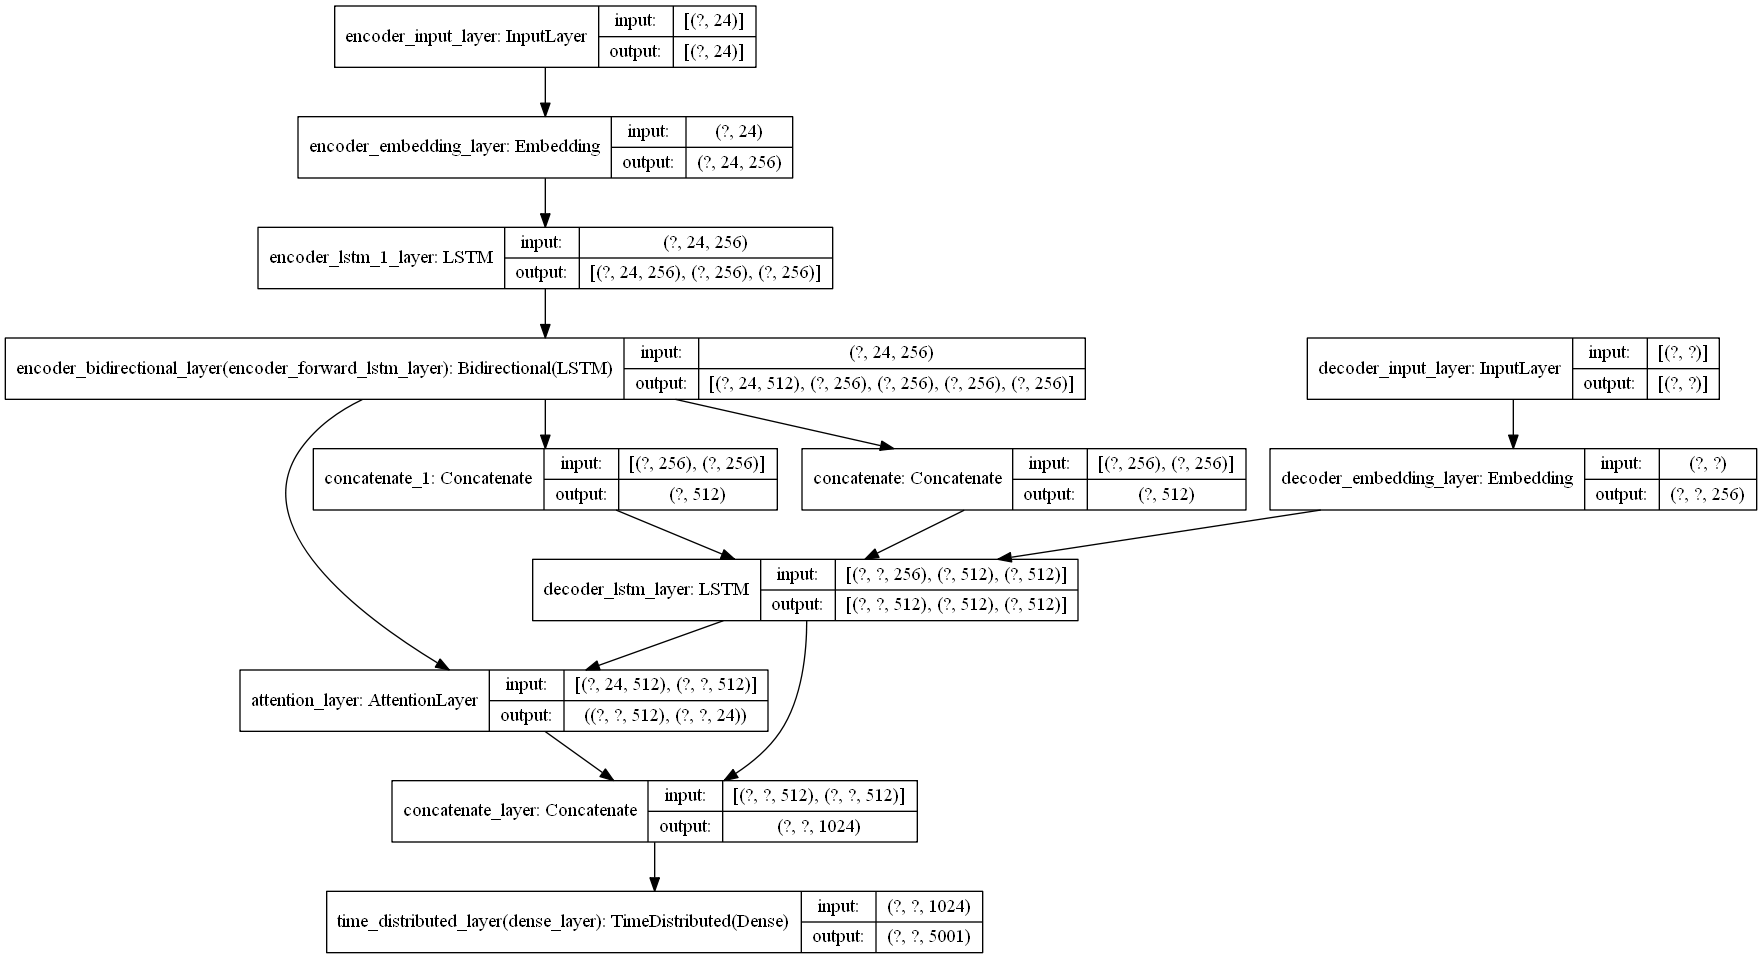

In [ ]:
class Encoder:
    def __init__(self, vocab_size, embedding_size, sequence_length):
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.sequence_length = sequence_length

        self.encoder_inputs = Input(shape=(self.sequence_length,),name="encoder_input_layer") 

        self.emb_layer     = Embedding(self.vocab_size+1, self.embedding_size,trainable=True,name="encoder_embedding_layer") 

        self.encoder_lstm1 = LSTM(self.embedding_size, return_sequences=True,return_state=True,name="encoder_lstm_1_layer") 

        self.encoder_lstm2 = LSTM(self.embedding_size, return_sequences=True,return_state=True,name="encoder_lstm_2_layer") 

        self.encoder_lstm3=  LSTM(self.embedding_size, return_state=True, return_sequences=True,name="encoder_lstm_3_layer") 


        #Code to try out bidirectional lstm
        self.encoder_lstm_forward  = LSTM(self.embedding_size, return_sequences=True,return_state=True,name="encoder_forward_lstm_layer") 

        self.encoder_lstm_backward = LSTM(self.embedding_size, return_state=True, return_sequences=True,go_backwards=True,name="encoder_backward_lstm_layer")

        self.encoder_bidirectional = Bidirectional(layer=self.encoder_lstm_forward,backward_layer=self.encoder_lstm_backward,name="encoder_bidirectional_layer")


    def build_encoder(self):
        enc_emb = self.emb_layer(self.encoder_inputs)

        encoder_output1, state_h1, state_c1 = self.encoder_lstm1(enc_emb) 

        encoder_output2, state_h2, state_c2 = self.encoder_lstm2(encoder_output1) 

        encoder_output3, state_h, state_c= self.encoder_lstm3(encoder_output2) 

        #Code to try out bidirectional lstm
        bidirect_output, forward_hidden, forward_cell, backward_hidden, backward_cell = self.encoder_bidirectional(encoder_output1)

        bid_state_h = Concatenate()([forward_hidden,backward_hidden])
        bid_state_c = Concatenate()([forward_cell, backward_cell])

        return bidirect_output, bid_state_h, bid_state_c

    def get_input(self):
        return self.encoder_inputs


class Decoder:
    def __init__(self, vocab_size, embedding_size, sequence_length):
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.sequence_length = sequence_length

        self.decoder_inputs = Input(shape=(None,),name="decoder_input_layer") 
        self.dec_emb_layer = Embedding(self.vocab_size+1, self.embedding_size,trainable=True,name="decoder_embedding_layer")

        #When using a bidirectional one can double the embedding size in the LSTM
        self.decoder_lstm = LSTM(self.embedding_size*2, return_sequences=True, return_state=True,name="decoder_lstm_layer") 

        self.attn_layer = AttentionLayer(name='attention_layer')

        self.concate_layer = Concatenate(axis=-1,name="concatenate_layer")

        self.dense = Dense(self.vocab_size+1, activation='softmax',name="dense_layer")

    def build_decoder(self, encoder_outputs,state_h,state_c):
        decoder_embeddings = self.dec_emb_layer(self.decoder_inputs) 

        decoder_outputs, decoder_fwd_state, decoder_back_state = self.decoder_lstm(decoder_embeddings,initial_state=[state_h, state_c]) 

        attention_output, attention_states = self.attn_layer([encoder_outputs, decoder_outputs])

        decoder_concat_input = self.concate_layer([decoder_outputs, attention_output])

        decoder_dense = TimeDistributed(self.dense,name="time_distributed_layer") 
        decoder_outputs = decoder_dense(decoder_concat_input) 

        return decoder_outputs

    def get_input(self):
        return self.decoder_inputs




# Attention Layer taken from https://github.com/harshilpatel99/NMT_english2marthi/blob/master/attention.py

# -*- coding: utf-8 -*-
"""attention.ipynb
Automatically generated by Colaboratory.
Original file is located at
    https://colab.research.google.com/drive/1XrjPL3O_szhahYZW0z9yhCl9qvIcJJYW
"""

import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "W_a": self.W_a,
            "U_a": self.U_a,
            "V_a": self.V_a
            })
        return config

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


# Initializing Encoder and Decoder
encoder = Encoder(src_vocab_size,EMBEDDING_SIZE,src_sequence_length)
encoder_output, encoder_hidden, encoder_cell = encoder.build_encoder()
encoder_inputs = encoder.get_input()

decoder = Decoder(tgt_vocab_size,EMBEDDING_SIZE,tgt_sequence_length)
decoder_outputs = decoder.build_decoder(encoder_output, encoder_hidden, encoder_cell)
decoder_inputs = decoder.get_input()



# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 

# Summarize the model
model.summary()
plot_model(model, to_file='train_model.png', show_shapes=True)

## **Training**<br/>
**-- Run this cell --**<br/>
Change the variable `load` to `0`, if a new model should be trained from scratch. Else leave as `1`. If set to `1`, the model which corresponds to the selected dataset will be used.

In [ ]:
load = 1 #  Change this

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

if load:
    model_name = None
    if dataset == 0:
        model_name = 'model_europarl.h5'
    elif dataset == 1:
        model_name = 'model_tmx.h5'
    elif dataset == 2:
        model_name = 'model_rapid.h5'
        
    # Load existing weights
    weights = model_name
    model.load_weights(weights)
    log("Weights loaded for " + model_name + " dataset.")
else:
    history = model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:], 
                        epochs=10, 
                        #callbacks=[es],
                        batch_size=256,
                        validation_data = ([x_validate, y_validate[:,:-1]], y_validate.reshape(y_validate.shape[0], y_validate.shape[1], 1)[:,1:]))
    fname = "model.h5"
    model.save_weights(fname)
    log("Model saved.")

[2021-06-30 00:41:57] --- [INFO]: Weights loaded for model_europarl.h5 dataset.


## **Inference**<br/>
**-- Run this cell --**<br/>
Defines the class which builds the the Inference model used for translation

In [ ]:
class Predictor:
    """
      Combines the Encoder and Decoder model for inferencing.
    """

    def __init__(self,model,src_id_word_word_id,tgt_id_word_word_id,max_length=32):
        self.encoder_model = None
        self.decoder_model = None

        # Vocab Dictionaries and maximum length of predicted sentence
        self.src_id_word_word_id = src_id_word_word_id
        self.tgt_id_word_word_id = tgt_id_word_word_id
        self.max_length = max_length
        
        
        ### --- Encoder Layers --- ###
        # Encoder Input Layer
        self.encoder_inputs = model.get_layer(name="encoder_input_layer")

        # Encoder Bidirectional Layer
        self.encoder_output = model.get_layer(name="encoder_bidirectional_layer")
        

        ### --- Decoder Layers --- ###
        # Decoder Initialization Layers
        self.decoder_state_input_h = Input(shape=(EMBEDDING_SIZE*2,)) # Final hidden state of the encoder OR previous hidden state of the decoder
        self.decoder_state_input_c = Input(shape=(EMBEDDING_SIZE*2,)) # Final cell state of the encoder OR previous cell state of the decoder
        self.decoder_hidden_and_context = Input(shape=(SEQUENCE_LENGTH,EMBEDDING_SIZE*2)) # Context Vector concatenated with the Hidden State of the Decoder

        # Decoder Input Layer
        self.decoder_inputs = model.get_layer(name="decoder_input_layer")

        # Decoder Embedding Layer
        self.dec_emb_layer = model.get_layer(name="decoder_embedding_layer")

        # Decoder LSTM Layer
        self.decoder_lstm = model.get_layer(name="decoder_lstm_layer")

        # Attention Layer
        self.attn_layer = model.get_layer(name="attention_layer")

        # Concatenate Layer
        self.concate = model.get_layer(name="concatenate_layer")

        # Time Distributed Layer (will output the probability distributions for the words)
        self.decoder_dense = model.get_layer(name="time_distributed_layer")

    def build(self):
        # unidirectional LSTM, uncomment this line
        #encoder_outputs, state_h, state_c = self.encoder_output.output #loading encoder_outputs

        ### --- Bidirectional Start
        # Loading Encoder outputs from the bidirectional layer (recieve 5 outputs)
        encoder_outputs, state_forward_h, state_forward_c,state_back_h,state_back_c = self.encoder_output.output

        # Concatenating forward and backwar states
        state_h = Concatenate()([state_forward_h,state_back_h])
        state_c = Concatenate()([state_forward_c,state_back_c])
        ### --- Bidirectional End

        ### Build the Encoder Model for Inferencing
        self.encoder_model = Model(inputs=self.encoder_inputs.input,outputs=[encoder_outputs, state_h, state_c])

        ### Combine Decoder Layers for Predictions
        # Decoder embeddings
        decoder_embeddings= self.dec_emb_layer(self.decoder_inputs.output)

        # To predict the next word in the sequence, set the initial states to the states from the previous time step
        decoder_outputs, decoder_hidden, decoder_cell = self.decoder_lstm(decoder_embeddings, initial_state=[self.decoder_state_input_h, self.decoder_state_input_c])

        # Getting the context vector from the attention. Context Vector holds information about the part f the input sequence which it should focus on
        attention_context, atten_weights = self.attn_layer([self.decoder_hidden_and_context, decoder_outputs])

        # Concatenate previous predictions with attention vector
        decoder_inf_concat = self.concate([decoder_outputs, attention_context])

        # will output the probability distributions for the words
        decoder_outputs = self.decoder_dense(decoder_inf_concat)

        ### --- Final decoder model --- ###
        self.decoder_model = Model(
        [self.decoder_inputs.output] + [self.decoder_hidden_and_context,self.decoder_state_input_h, self.decoder_state_input_c],
        [decoder_outputs] + [decoder_hidden, decoder_cell])

    def translate(self,input_seq):
        # Encode the input sequence to state vectors
        encoder_output, encoder_hidden, encoder_cell = self.encoder_model.predict(input_seq)

        # Start token to initialize the translation process
        target_seq = np.zeros((1,1))
        # Chose the 'start' word as the first word of the target sequence
        target_seq[0, 0] = self.tgt_id_word_word_id[1][SOS]

        # Predicting words until the end token is sampled
        stop_condition = False
        decoded_sentence = ''
        while not stop_condition:
            # Actually predict the next word
            output_probabilities, h, c = self.decoder_model.predict([target_seq] + [encoder_output, encoder_hidden, encoder_cell])

            # Get the token with highest probability
            sampled_token_index = np.argmax(output_probabilities[0, -1, :])

            # Avoid looping. If the sampled index is 0, then that means that we sampled the same token as before. Therefore break.
            # Also this avoids a key error because '0' is not in the dictionary
            if sampled_token_index == 0:
                break
            else:
                # Get the string word
                sampled_token = self.tgt_id_word_word_id[0][sampled_token_index]

                """
                    To deal with tht <unk> token we sample the second highest token in the
                    outputs (which contains probabilities)
                """
                if sampled_token == UNK:
                    output_probabilities[0, -1, :][sampled_token_index] = 0
                    highest_prob_index = np.argmax(output_probabilities[0, -1, :])
                    if highest_prob_index == 0:
                        break
                    else:
                        sampled_token = self.tgt_id_word_word_id[0][highest_prob_index]

            # While we don't predict <eos>, generate new words
            if (sampled_token!=EOS):
                decoded_sentence += ' '+sampled_token

                if (sampled_token == EOS or len(decoded_sentence.split()) >= (self.max_length)):
                    stop_condition = True

            # Update the "previously generated word" sequence to the current word
            target_seq = np.zeros((1,1))
            target_seq[0, 0] = sampled_token_index

            # Update internal states
            encoder_hidden, encoder_cell = h, c

        return decoded_sentence


    def decode_target_sequence(self,input_seq):
        """
          Convert a sequence to natural language sentence using the target vocabulary
        """
        output = ''
        # For each word_id
        for i in input_seq:

            # If word_id is not a padding, not the <sos> and not <eos>
            if ((i != 0 and i != self.tgt_id_word_word_id[1][SOS]) and i != self.tgt_id_word_word_id[1][EOS]):
                output += self.tgt_id_word_word_id[0][i] + ' '

        return output.strip()

    def decode_source_sequence(self,input_seq):
        """
          Convert a sequence to natural language sentence using the target vocabulary
        """
        output = ''
        # For each word_id
        for i in input_seq:

            # If word_id is not padding
            if (i != 0):
                output += self.src_id_word_word_id[0][i] + ' '
        
        return output.strip()

# Initialize Predictor
predictor = Predictor(model,src_id_word_word_id,tgt_id_word_word_id,32)
predictor.build()

**-- (Optional) Run this cell --**<br/>
This cell can be used for translation sentences.

In [ ]:
# Predict on TEST dataset
for i in range(10):
    print("German:",predictor.decode_source_sequence(x_test[i]))
    print("Original English:",predictor.decode_target_sequence(y_test[i]))
    print("Predicted English:",predictor.translate(x_test[i].reshape(1,src_sequence_length)))
    print("\n")

German: <sos> dieses papier in dieser kurze ist eine <unk> ! <eos>
Original English: a paper this short is a <unk> .
Predicted English:  this paper is a key of .


German: <sos> wichtig ist , da wir zu einem zeitpunkt , da wir uns mit dem <unk> insgesamt beschaftigen , das richtige signal aussenden <eos>
Original English: at a time when we are looking at the whole reform process it is critical that we send the right signal .
Predicted English:  it is important that we should be at a time when we are dealing with the overall of , which is a


German: <sos> ich mochte nur daran erinnern , da der gerichtshof , wie sie sicher besser wissen als ich , <unk> eine entscheidung in <eos>
Original English: let me simply remind you that the court of justice pronounced a ruling on this in 1982 , as you know better
Predicted English:  i would just like to remind you that the court , as you know , is a decision in the council of


German: <sos> obwohl ich nicht dafur <unk> , da jenen <unk> zugang zu 

**-- (Optional) Run this cell --**<br/>
This cell evaluates the BLEU scores for the test data

In [ ]:
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
total = len(x_test)
for i in range(total):
    if i % 350 == 0:
        print(str(i) + "/" + str(total))
    original = predictor.decode_target_sequence(y_test[i])
    predicted = predictor.translate(x_test[i].reshape(1,src_sequence_length))

    score1 = sentence_bleu([original], predicted, weights=(1, 0,0,0))
    score2 = sentence_bleu([original], predicted, weights=(0.5, 0.5, 0, 0))
    score3 = sentence_bleu([original], predicted, weights=(0.33, 0.33, 0.33, ))
    score4 = sentence_bleu([original], predicted)
    bleu1.append(score1)
    bleu2.append(score2)
    bleu3.append(score3)
    bleu4.append(score4)

# Average scores
avg1 = np.average(bleu1)*100
avg2 = np.average(bleu2)*100
avg3 = np.average(bleu3)*100
avg4 = np.average(bleu4)*100

print("BLEU-1: ", avg1)
print("BLEU-2: ", avg2)
print("BLEU-3: ", avg3)
print("BLEU-4: ", avg4)

0/1500


C:\ProgramData\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\ProgramData\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\ProgramData\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin

350/1500
700/1500
1050/1500
1400/1500
BLEU-1:  72.70393602006477
BLEU-2:  61.78916086239609
BLEU-3:  53.95898715413507
BLEU-4:  48.006984650541106
